# Streetaware - Object Detection Data

In [2]:
import pandas as pd
import numpy as np
import time
import json
import os
import pickle
import sys
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.express.colors import sample_colorscale
np.random.seed(2024)
sys.path.append('../..')

from topomap.visualizations import plot_topomap_comparison_highlight, plot_hierarchical_treemap


from topomap import TopoTree
from topomap import TopoMap
from topomap import HierarchicalTopoMap
from topomap.utils import get_hull

In [3]:
def process_embedding_data(base_path, street, side):
    embeddings_path = base_path+f'{street}_1_sensor_1_{side}_crop_embeddings.pkl'
    data_path = base_path+f'{side}_detections.json'

    with open(embeddings_path, 'rb') as f:
        original_emb = np.load(f, allow_pickle=True)

    with open(data_path, 'rb') as f:
        data = json.load(f)
        
    list_emb = []
    list_classes = []
    list_bbox = []
    list_scores = []
    
    n_frames = len(original_emb)
    list_id_frames = []

    for frame in range(n_frames):

        emb_frame = original_emb[frame]
        n_obj_frame = len(emb_frame)

        for i in range(n_obj_frame):
            list_emb.append(emb_frame[i,:])

        list_id_frames.extend([frame]*n_obj_frame)        

        list_classes.extend(data[frame]['classIDs'])
        list_bbox.extend(data[frame]['boundingBoxes'])
        list_scores.extend(data[frame]['scores'])

    all_emb = np.array(list_emb)
    all_classes = np.array(list_classes)
    all_bbox = np.array(list_bbox)
    all_scores = np.array(list_scores)

    all_id_frames = np.array(list_id_frames)

    select_classes = [0, #peson
                      1, #bicycle
                      2, #car
                     ]

    emb = np.zeros((0, 768))
    classes = []
    bboxes = []
    scores = []
    id_frames = []

    for c in select_classes:
        mask_class = all_classes == c
        emb = np.vstack([emb, all_emb[mask_class,:]])
        classes.extend(mask_class.sum()*[c])
        bboxes.extend(all_bbox[mask_class,:])
        scores.extend(all_scores[mask_class])
        id_frames.extend(all_id_frames[mask_class])


    classes = np.array(classes)
    bboxes = np.array(bboxes)
    scores = np.array(scores)
    id_frames = np.array(id_frames)

    return emb, classes, bboxes, scores, id_frames

In [4]:
def crop_frame(ids_frames, bboxs, video_path):
    import cv2
    import matplotlib.pyplot as plt
    video = cv2.VideoCapture(video_path)
    results = []
    for index, id_frame in enumerate(ids_frames):
        video.set(cv2.CAP_PROP_POS_FRAMES, id_frame)
        ret, frame = video.read()

    
        x1,y1,x2,y2 = bboxs[index]
    
        cropped_image = frame[y1:y2,x1:x2,:]
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        results.append(cropped_image)
    
    return results

def plot_grid(images):
    fig, axs = plt.subplots(2, 5)
    for i, image in enumerate(images):
        row = i//5
        column = i%5
        axs[row][column].imshow(image)
    
        axs[row][column].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    fig.tight_layout()
    return fig


def plot_projections_color_scale(projections,
                                    df_data,
                                    color_scale = "teal",
                                    column='score',
                                    colors=[],
                                    hiertopomap=None,
                                    legend_title='_',
                                    low_opacity=False,
                                    show_hulls=True,
                                    topomap=False,
                                    columns_to_ignore = [],
                                    ):
    

    

    fig = go.Figure()

    if show_hulls:
        for c in hiertopomap.components_to_scale:
            comp_ids = hiertopomap.components_info[c]['points']

            if topomap:
                hull = hiertopomap.components_info[c]['hull']
                points = np.array(projections[comp_ids])
                if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(comp_ids)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    points = points[~mask]
                hull = get_hull(points)
                points_hull = [points[i] for i in hull.vertices]
                points_hull.append(points_hull[0])
                xs, ys = zip(*points_hull)

            else:
                hull = hiertopomap.components_info[c]['hull']
                points_ids = np.array([comp_ids[i] for i in hull.vertices])
                if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(points_ids)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    points_ids = points_ids[~mask]
                points = list(hiertopomap.projections[points_ids,:])
                points.append(points[0])
                xs, ys = zip(*points)

            fig.add_trace(go.Scatter(x=xs, y=ys,
                            fill='toself', 
                            fillcolor = '#CCCCCC',
                            line_color='#808080',
                            opacity=0.5,
                            line_width=1,
                            text=f'Component {c}',
                            name='Components', legendgroup='Components',
                            showlegend=False,
                            marker=dict(size=1)
                            )
                        )

    if low_opacity:
        opacity_points = 0.2
    else:
        opacity_points = 1

    
    scores =  np.array(df_data[column].tolist())
    points_ids = np.array(range(len(df_data.index))) 
    if(len(columns_to_ignore)!=0):
                filtered_df = df_data
                mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                points_ids = points_ids[~mask]
                scores = scores[~mask]
    
    colors =sample_colorscale(color_scale,scores)
   
    

    fig.add_trace(go.Scatter(x=projections[points_ids,0], 
                            y=projections[points_ids,1],
                            mode='markers',
                            opacity=opacity_points,
                            marker_color = scores,
                            marker=dict(
                                colorscale=color_scale,
                                size=2,
                                colorbar=dict(title='scores')
                            ),
                            showlegend=False
                            )
                        )
    
    if low_opacity: 
        for c in hiertopomap.components_to_scale:
            comp_ids = hiertopomap.components_info[c]['points']
            
            points_id = np.array(range(len(df_data.index)))
            points_id = np.array(np.intersect1d(points_id, comp_ids))
            scores = np.array(df_data[column].tolist())

            
            

            if len(points_id) > 0:
                if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(points_id)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    # print(mask)
                    points_id = points_id[~mask]
                
                scores = scores[points_ids]

                # colors = sample_colorscale(color_scale,scores)
                
                fig.add_trace(go.Scatter(x=projections[points_ids,0], 
                            y=projections[points_ids,1],
                            mode='markers',
                            opacity=1,
                            marker_color = scores,
                            marker=dict(
                                colorscale=color_scale,
                                size=2,
                                colorbar=dict(title='scores')
                            ),
                            showlegend=False
                            )
                        )
        
    fig.update_layout(margin = dict(t=25, l=25, r=25, b=25),
                        height=500,
                        width=550,
                        legend= {'itemsizing': 'constant',
                        'title': legend_title},
                        plot_bgcolor = "white",
                        xaxis=dict(showticklabels=False,
                        showline=True, linewidth=1, linecolor='black', mirror=True), 
                        yaxis=dict(showticklabels=False,
                        showline=True, linewidth=1, linecolor='black', mirror=True),
                    )
    
    return fig


def plot_projections_discrete_feature(projections,
                                    df_data,
                                    column_color,
                                    column_values=[],
                                    colors=[],
                                    hiertopomap=None,
                                    legend_title='',
                                    low_opacity=False,
                                    show_hulls=True,
                                    topomap=False,
                                    columns_to_ignore = []
                                    ):
    if len(column_values) == 0:
        column_values = list(df_data[column_color].unique())
    if len(colors)==0:
        colors = px.colors.qualitative.T10
    if legend_title=='':
        legend_title=column_color

    fig = go.Figure()

    if show_hulls:
        for c in hiertopomap.components_to_scale:
            comp_ids = hiertopomap.components_info[c]['points']

            if topomap:
                hull = hiertopomap.components_info[c]['hull']
                points = np.array(projections[comp_ids])
                if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(comp_ids)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    points = points[~mask]
                hull = get_hull(points)
                points_hull = [points[i] for i in hull.vertices]
                points_hull.append(points_hull[0])
                xs, ys = zip(*points_hull)

            else:
                hull = hiertopomap.components_info[c]['hull']
                points_ids = np.array([comp_ids[i] for i in hull.vertices])
                if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(points_ids)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    points_ids = points_ids[~mask]
                points = list(hiertopomap.projections[points_ids,:])
                points.append(points[0])
                xs, ys = zip(*points)

            fig.add_trace(go.Scatter(x=xs, y=ys,
                            fill='toself', 
                            fillcolor = '#CCCCCC',
                            line_color='#808080',
                            opacity=0.5,
                            line_width=1,
                            text=f'Component {c}',
                            name='Components', legendgroup='Components',
                            showlegend=False,
                            marker=dict(size=1)
                            )
                        )

    if low_opacity:
        opacity_points = 0.2
    else:
        opacity_points = 1

    for i,c in enumerate(column_values):
        points_id = np.array(df_data[df_data[column_color]==c].index.to_list())
        if(len(columns_to_ignore)!=0):
                    filtered_df = df_data[df_data.index.isin(points_id)]
                    mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                    points_id = points_id[~mask]
        fig.add_trace(go.Scatter(x=projections[points_id,0], 
                                y=projections[points_id,1],
                                customdata=points_id,
                                mode='markers',
                                opacity=opacity_points,
                                marker=dict(
                                    color=colors[i],
                                    size=2,
                                ),
                                name=str(c),
                                showlegend=True
                                )
            )

    if low_opacity: 
        for c in hiertopomap.components_to_scale:
            comp_ids = hiertopomap.components_info[c]['points']
            for i,v in enumerate(column_values):
                points_id = df_data[df_data[column_color]==v].index.to_list()
                points_id = np.intersect1d(points_id, comp_ids)

                if len(points_id) > 0:
                    if(len(columns_to_ignore)!=0):
                        filtered_df = df_data[df_data.index.isin(points_id)]
                        mask = np.array(filtered_df['class'].isin(columns_to_ignore).tolist())
                        points_id = points_id[~mask]

                    fig.add_trace(go.Scatter(x=projections[points_id,0], 
                                            y=projections[points_id,1],
                                            mode='markers',
                                            opacity=1,
                                            marker=dict(
                                                color=colors[i],
                                                size=2,
                                            ),
                                            name=str(v),
                                            legendgroup=str(v),
                                            showlegend=False
                                            )
                        )
        
    fig.update_layout(margin = dict(t=25, l=25, r=25, b=25),
                        height=500,
                        width=550,
                        legend= {'itemsizing': 'constant',
                        'title': legend_title},
                        plot_bgcolor = "white",
                        xaxis=dict(showticklabels=False,
                        showline=True, linewidth=1, linecolor='black', mirror=True), 
                        yaxis=dict(showticklabels=False,
                        showline=True, linewidth=1, linecolor='black', mirror=True),
                    )
    
    return fig


In [5]:
street = 'chase'
side = 'left'
base_path = f'../../data/streetaware/{street}/'

if os.path.isfile(base_path+'embeddings.npy'):
    with open(base_path+'embeddings.npy', 'rb') as f:
        emb = np.load(f)
    with open(base_path+'classes.npy', 'rb') as f:
        classes = np.load(f)

    with open(base_path+'bboxes.npy', 'rb') as f:
        bboxes = np.load(f)
    
    with open(base_path+'scores.npy', 'rb') as f:
        scores = np.load(f)

    with open(base_path+'id_frames.npy', 'rb') as f:
        id_frames = np.load(f)

else:
    emb, classes, bboxes, scores, id_frames = process_embedding_data(base_path, street, side)

    with open(base_path+'embeddings.npy', 'wb') as f:
        np.save(f, emb)

    with open(base_path+'classes.npy', 'wb') as f:
        np.save(f, classes)
    
    with open(base_path+'bboxes.npy', 'wb') as f:
        np.save(f, bboxes)
    
    with open(base_path+'scores.npy', 'wb') as f:
        np.save(f, scores)

    with open(base_path+'id_frames.npy', 'wb') as f:
        np.save(f, id_frames)


In [6]:
unique, counts = np.unique(classes, return_counts=True)
component_dict = dict(zip(unique, counts))
print(component_dict)

{0: 237231, 1: 3279, 2: 122624}


In [18]:
proj_topomap_path = '../../data/saved_TopomapsStreetAware/street_aware_topomap_proj.npy'
df_comp_path = "../../data/saved_TopomapsStreetAware/street_aware_df_comp_samples.pkl"
sorted_edges_path = '../../data/saved_TopomapsStreetAware/street_aware_mst_proj.npy'
mst_path = '../../data/msts/mst_StreetAware.npy'
hier_proj_path = "../../data/saved_TopomapsStreetAware/street_aware_proj_hier.npy"
hier_topomap_path = '../../data/saved_TopomapsStreetAware/hiertopomap.pickle'



proj_topomap = np.load(proj_topomap_path)
df_comp = pd.read_pickle(df_comp_path)
sorted_edges = np.load(sorted_edges_path, allow_pickle= True)
mst = np.load(mst_path, allow_pickle = True)
if(not os.path.exists(hier_topomap_path)):
    
    start_time = time.time()

    hiertopomap = HierarchicalTopoMap(
                                    k_components=6)

    hiertopomap.min_points_component = 0.01*emb.shape[0]
    hiertopomap.mst = mst
    hiertopomap.sorted_edges = sorted_edges
    proj_hier_samples = hiertopomap.fit_transform(emb)

    hiertopomap_time = time.time()-start_time
    print(f'Time for runinning HierarchicalTopoMap: {hiertopomap_time}s')

    with open('../../data/saved_TopomapsStreetAware/hiertopomap.pickle', 'wb') as f:
        pickle.dump(hiertopomap,f)
hier_proj = np.load(hier_proj_path,allow_pickle=True)
with open(hier_topomap_path, 'rb') as handle:
    hiertopomap = pickle.load(handle)

components_to_highligth = hiertopomap.components_to_scale

df_points = pd.DataFrame({"score":scores, "class":classes})
df_points.loc[df_points['class'] == 0, 'class'] = "person"
df_points.loc[df_points['class'] == 1, 'class'] = "bike"
df_points.loc[df_points['class'] == 2, 'class'] = "car"

C:\Users\felip\AppData\Local\Temp\ipykernel_1292\3766876021.py:38: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'person' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.



In [12]:
fig = plot_hierarchical_treemap(df_comp, color='died_at')
fig.update_layout(title='TopoTree - Streetaware Dataset')
fig.show()

if you face any problems when running fig.write_image on windows, please downgrade kaleido to 0.1. As we write this code this is still an open bug in plotly (https://github.com/plotly/Kaleido/issues/110)

In [19]:

fig = plot_topomap_comparison_highlight(proj_topomap, hier_proj, 
                                               components_to_highligth, df_comp,
                                               hiertopomap)
fig.update_layout(height=600, width=1200, title='Streetaware Dataset')
fig.write_image("../../images/Comparison-Street_Aware.png")

In [20]:
import matplotlib.pyplot as plt
import numpy as np
classes_components = []
names = []
for component in components_to_highligth:
    points = df_comp.loc[component]["points"]
    # print(type(points))
    labels = classes[points]
    unique, counts = np.unique(labels, return_counts=True)
    component_dict = dict(zip(unique, counts))
    component_dict["person"] = component_dict.pop(0) if 0 in component_dict.keys() else 0
    component_dict["bicycle"] = component_dict.pop(1) if 1 in component_dict.keys() else 0
    component_dict["car"] = component_dict.pop(2) if 2 in component_dict.keys() else 0 
    classes_components.append(component_dict)
    names.append(f'Component {component}')

df_classes_components = pd.DataFrame.from_records(classes_components, index = names)
print(df_classes_components)

             person  bicycle    car
Component 0       0        0  30085
Component 1       0        0  26050
Component 4   18868        0      0
Component 2       0        0   9159
Component 9       0        0   5472
Component 3    4505        0      0


In [21]:
import numpy as np
classes_components = np.full(len(emb), fill_value= 'other', dtype= object)

for component in components_to_highligth:
    points = df_comp.loc[component]["points"]
    # print(type(points))
    classes_components[points] = str(component)

df_points["component"] = classes_components

component 0
component 1
component 4
component 2
component 9
component 3


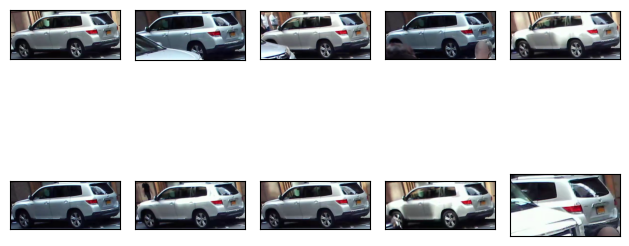

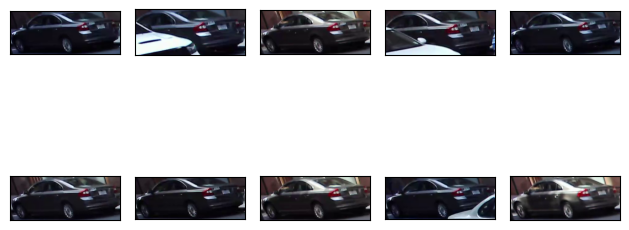

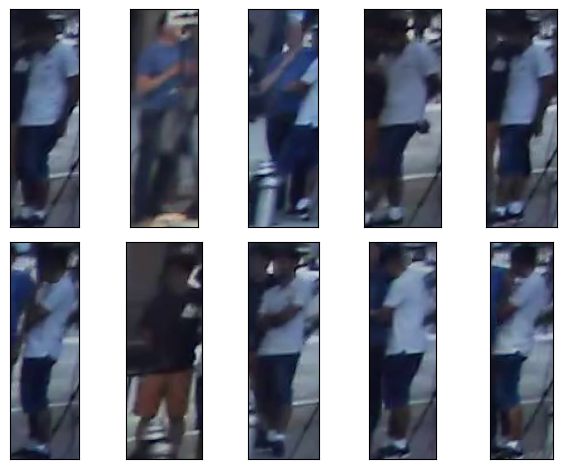

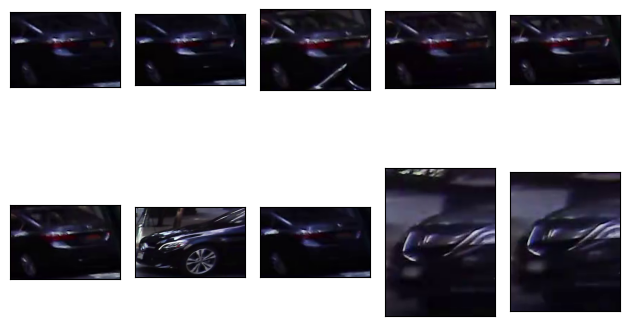

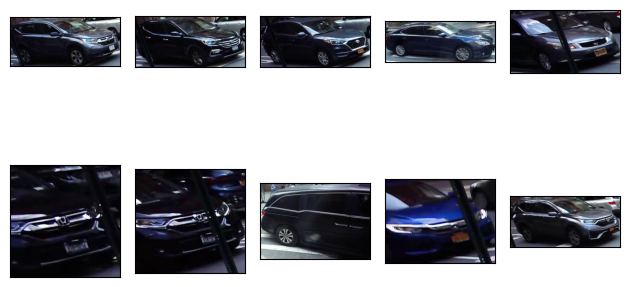

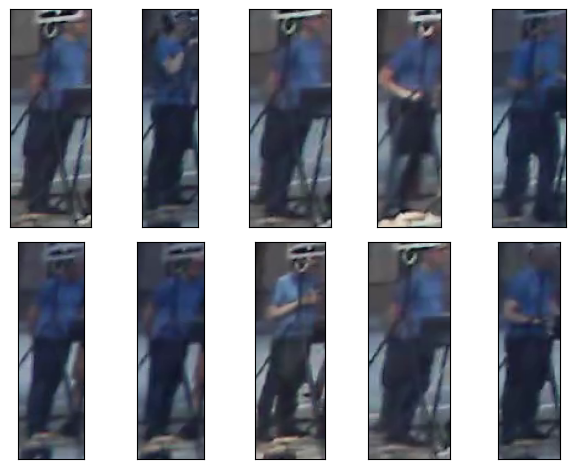

In [22]:
video_path = base_path + 'left.mp4'
for component in components_to_highligth:
    points = np.array(df_comp.loc[component]["points"])
    n_points = len(points)
    if n_points>10:
        mask = np.random.randint(0,n_points,10)
    else:
        mask = range(10)
    s_points = points[mask]
    s_labels = classes[s_points]
    s_bboxes = bboxes[s_points]
    s_ids = id_frames[s_points]
    croped_images = crop_frame(s_ids,s_bboxes,video_path)
    fig = plot_grid(croped_images)
    print(f'component {component}')

In [23]:

fig = plot_projections_discrete_feature(hier_proj,
                                        df_points,
                                        column_color = 'class',
                                        legend_title='Class',
                                        column_values=['person','bike','car'],
                                        hiertopomap=hiertopomap,
                                        low_opacity= True,
                                        columns_to_ignore=['bike'])
fig.update_layout(height=600, width=600, title='Streetaware Dataset')
fig.write_image("../../images/Street_Aware_by_class.png")

In [24]:
fig = plot_projections_discrete_feature(hier_proj,
                                        df_points,
                                        column_color = "component",
                                        legend_title='Component',
                                        hiertopomap=hiertopomap,
                                        low_opacity= True,
                                        topomap = True,
                                        columns_to_ignore=['bike'])
fig.update_layout(height=600, width=600, title='Streetaware Dataset')
fig.write_image("../../images/Street_Aware_Topomap2.png")

In [25]:
fig = plot_projections_color_scale(hier_proj,
                                   df_points,
                                   color_scale="agsunset",
                                   column = 'score',
                                   hiertopomap=hiertopomap,
                                   low_opacity = False,
                                   columns_to_ignore=['bike']

)
fig.update_layout(height=600, width=600, title='Streetaware scores')
fig.write_image("../../images/Street_Aware_scores3.png")

In [26]:
def save_figures_component(ids_frames, bboxs, video_path, names, folder_path):
    from pathlib import Path
    import cv2
    Path(folder_path).mkdir(parents=True, exist_ok=True)
    n_images = len(ids_frames)
    # print(n_images)
    if(n_images > 100):
        mask = np.random.randint(0,n_images,100)
    else:
        mask = range(n_images)
    # print(mask)
    s_id_frames = ids_frames[mask]
    s_bboxes = bboxs[mask]
    s_names = names[mask]
    croped_images = crop_frame(s_id_frames,s_bboxes,video_path)
    for idx,image in enumerate(croped_images):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"{folder_path}_{s_names[idx]}.png", image)

In [11]:
video_path = base_path + 'left.mp4'
for component in components_to_highligth:
    points = np.array(df_comp.loc[component]["points"])
    s_points = points
    s_labels = classes[s_points]
    s_bboxes = bboxes[s_points]
    s_ids = id_frames[s_points]
    s_scores = scores[s_points]
    names = np.array([f'id_{points[i]}_label_{s_labels[i]}_score_{s_scores[i]:.2f}' for i in range(len(points))],dtype = object)
    save_figures_component(s_ids,s_bboxes,video_path,names,f"./CaseStudy/StreetAware/sampled_rc/component_{component}/")

In [27]:
import matplotlib.pyplot as plt
import numpy as np
names = []
statistics = []
for component in components_to_highligth:
    points = df_comp.loc[component]["points"]
    # print(type(points))
    scrs = scores[points]
    mean = np.mean(scrs, dtype=np.float64)
    std = np.std(scrs, dtype = np.float64)
    row_dict = {"mean": mean, "std":std}
    statistics.append(row_dict)
    names.append(f'Component {component}')
df_statistics = pd.DataFrame.from_records(statistics, index = names)
print(df_statistics)

                 mean       std
Component 0  0.907157  0.033370
Component 1  0.858717  0.106169
Component 4  0.590836  0.133034
Component 2  0.726262  0.069238
Component 9  0.913747  0.037774
Component 3  0.686724  0.053900
